# Quick Start Tutorial

GluonTS contains:

* A number of pre-built models
* Components for building new models (likelihoods, feature processing pipelines, calendar features etc.)
* Data loading and processing
* Plotting and evaluation facilities
* Artificial and real datasets (only external datasets with blessed license)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
from logger import *

In [4]:
config = {
        "epochs": 10,
        "dataset":"traffic_nips",
}
logger = Logger()

exp_agent = Experiment_Agent(config=config)
exp_agent.init_new_exp()
exp_agent.run_exp(timestamp = logger.timestamp)

['times:1\n', 'epochs:10\n', 'dataset:traffic_nips\n', 'timestamp:2024-04-16-23-41-39\n']


## Datasets

### Provided datasets

GluonTS comes with a number of publicly available datasets.

In [5]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

/root/miniconda3/lib/python3.8/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [6]:
print(f"Available datasets: {dataset_names}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again the next time around.

In [7]:
dataset = get_dataset(config["dataset"])

## Training an existing model (`Estimator`)

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GluonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of an `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [8]:
# from gluonts.mx import SimpleFeedForwardEstimator, Trainer
from gluonts.torch.model.deepar import DeepAREstimator

In [9]:
'''
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)
'''
estimator = DeepAREstimator(freq = dataset.metadata.freq, prediction_length=dataset.metadata.prediction_length,context_length=504,
                           trainer_kwargs = {"max_epochs":config["epochs"]})

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

In [10]:
predictor = estimator.train(dataset.train)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/root/miniconda3/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name  | Type        | Params | In sizes                                                         | Out sizes   
------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 27.6 K | [[1, 1], [1, 1], [1, 1224, 5], [1, 1224], [1, 122

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached -2.01914 (best -2.01914), saving model to '/root/tcn/base/deepar/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.01914 (best -2.01914), saving model to '/root/tcn/base/deepar/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -2.72436 (best -2.72436), saving model to '/root/tcn/base/deepar/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.72436 (best -2.72436), saving model to '/root/tcn/base/deepar/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -3.03397 (best -3.03397), saving model to '/root/tcn/base/deepar/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as t

In [11]:
logger.finish(config=config)

## Visualize and evaluate forecasts

With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [12]:
from gluonts.evaluation import make_evaluation_predictions

In [13]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [14]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

In [15]:
# first entry of the time series list
ts_entry = tss[0]

In [16]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

array([0.00973333, 0.00661667, 0.00618333, 0.00896667, 0.01836667],
      dtype=float32)

In [17]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [18]:
# first 5 values
dataset_test_entry["target"][:5]

array([0.00973333, 0.00661667, 0.00618333, 0.00896667, 0.01836667],
      dtype=float32)

The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all this information by simply invoking the corresponding attribute of the forecast object.

In [19]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [20]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2008-06-15 17:00
Frequency of the time series: <Hour>


We can also do calculations to summarize the sample paths, such as computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [21]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [0.02516775 0.02126585 0.0163271  0.01377304 0.01299173 0.00961198
 0.00585591 0.00363814 0.0023048  0.00174709 0.00150194 0.00350096
 0.01037297 0.01213657 0.01361257 0.01761997 0.02169696 0.02530036
 0.02680915 0.02490477 0.02696327 0.02618487 0.02631132 0.024587  ]
0.5-quantile (median) of the future window:
 [0.02555088 0.02118668 0.01636351 0.01370244 0.01293348 0.00975659
 0.00580528 0.00372971 0.00232636 0.00175149 0.00147807 0.00350851
 0.01040106 0.0122854  0.01322012 0.01793482 0.021667   0.0247759
 0.02695833 0.02871197 0.02705256 0.02690635 0.02638062 0.02477197]


`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

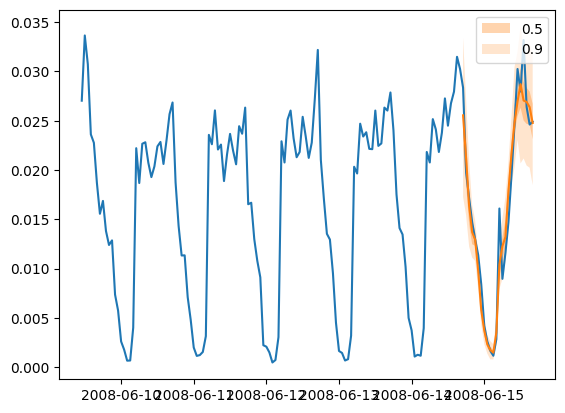

In [22]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [23]:
from gluonts.evaluation import Evaluator

In [ ]:
evaluator = Evaluator(quantiles=(np.arange(20)/20.0)[1:])
agg_metrics, item_metrics = evaluator(tss, forecasts)
pd.DataFrame.from_records(agg_metrics, index=["FeedForward"]).transpose().to_csv(logger.evaluate_to_log_name())

Running evaluation: 6741it [00:03, 1727.76it/s]


The aggregate metrics, `agg_metrics`, aggregate both across time-steps and across time series.

In [ ]:
print(json.dumps(agg_metrics, indent=4))

Individual metrics are aggregated only across time-steps.

In [ ]:
item_metrics.head()

In [ ]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()